In [1]:
import numpy as np
import matplotlib.pylab as plt
import blimpy as bl
%matplotlib inline

In [2]:
from typing import List, Tuple

from astropy.time import Time
from astropy import units as u

In [3]:
# MAX_IMSHOW_POINTS   = (8192, 4096)           # Max number of points in imshow plot


# def plot_waterfall(fil, f_start=None, f_stop=None, if_id=0, 
#                    logged=True, cb=False, freq_label=False, MJD_time=False, **kwargs):
#     """ Plot waterfall of data
#     Args:
#         f_start (float): start frequency, in MHz
#         f_stop (float): stop frequency, in MHz
#         logged (bool): Plot in linear (False) or dB units (True),
#         cb (bool): for plotting the colorbar
#         kwargs: keyword args to be passed to matplotlib imshow()
#     """


#     plt.rc('font', size=12)

#     plot_f, plot_data = fil.grab_data(f_start, f_stop, if_id)

#     # Make sure waterfall plot is under 4k*4k
#     dec_fac_x, dec_fac_y = 1, 1
#     if plot_data.shape[0] > MAX_IMSHOW_POINTS[0]:
#         dec_fac_x = plot_data.shape[0] / MAX_IMSHOW_POINTS[0]

#     if plot_data.shape[1] > MAX_IMSHOW_POINTS[1]:
#         dec_fac_y =  plot_data.shape[1] /  MAX_IMSHOW_POINTS[1]

#     #print(dec_fac_x)
        
#     plot_data = bl.utils.rebin(plot_data, int(dec_fac_x), int(dec_fac_y))
    
#     plot_data = np.fliplr(plot_data)
#     plot_f = np.flipud(plot_f)

#     if MJD_time:
#         extent=(plot_f[0], plot_f[-1], fil.timestamps[-1], fil.timestamps[0])
#     else:
#         extent=(plot_f[0], plot_f[-1], (fil.timestamps[-1]-fil.timestamps[0])*24.*60.*60, 0.0)

#     this_plot = plt.imshow(plot_data,
#         aspect='auto',
#         rasterized=True,
#         interpolation='nearest',
#         extent=extent,
#         cmap='hot',
#         **kwargs
#     )
#     if cb:
#         plt.colorbar()

#     if freq_label:
#         plt.xlabel("Frequency (Hz)")
#     if MJD_time:
#         plt.ylabel("Time (MJD)")
#     else:
#         plt.ylabel("Time (s)")

# #    print('this is plot_data:', plot_data)
# #    print('this is plot_data\'s shape:', plot_data.shape)
# #    print('this is plot_f:', plot_f)
# #    print('this is plot_f\'s shape', plot_f.shape)
    
#     return this_plot

# def make_waterfall_plots(filenames_list, target, f_start, f_stop, ion=False, correction_in=0, 
#                          line1=None, line2=None, **kwargs):
#     ''' Makes waterfall plots per group of ON-OFF pairs (up to 6 plots.)
#     '''

#     plt.rc('font', size=12)

#     if ion:
#         plt.ion()

#     n_plots = len(filenames_list)
#     fig = plt.subplots(n_plots, sharex=True, sharey=True)
# #    fig = plt.subplots(n_plots, sharex=True, sharey=True, figsize=(10, 2*n_plots))
# #    fig = plt.subplots(1, 2, 1, sharex=True, sharey=True)

#     fil = bl.Waterfall(filenames_list[0], f_start=f_start, f_stop=f_stop)
    
#     A1_avg = np.median(fil.data)
#     A1_max = fil.data.max()
#     A1_std = np.std(fil.data)

#     labeling = ['A','B','A','C','A','D']

#     delta_f = np.abs(f_start-f_stop)
#     mid_f = np.abs(f_start+f_stop)/2.
    
#     #Adjust the incorrect header data
#     correction = mid_f - correction_in
#     mid_f_text = mid_f - correction

#     for i,filename in enumerate(filenames_list):
#         plt.subplot(n_plots, 2, (2 * i) + 1)

#         fil = bl.Waterfall(filename, f_start=f_start, f_stop=f_stop)

#         this_plot = plot_waterfall(fil,f_start=f_start, f_stop=f_stop,
#                                    vmin=A1_avg-A1_std*0,vmax=A1_avg+5.*A1_std,**kwargs)
        
#         if line1 != None:
#             plt.axvline(x=line1, color = 'white', ls='--')
#         if line2 != None:
#             plt.axvline(x=line2, color = 'white', ls='--')

#         if i == 0:
#             plt.title('Waterfall')

#         if i < len(filenames_list)-1:
#             plt.xticks(np.arange(f_start, f_stop, delta_f/4.), ['','','',''])

#     #Some plot formatting.
#     ax = plt.gca()
#     #ax.invert_xaxis()
#     ax.get_xaxis().get_major_formatter().set_useOffset(False)
    
#     if target == 'HIP7981':
#         #f_start -= 0.3
#         #f_stop  += 0.3
#         factor = 1e3
#         units = 'kHz'
#     else:
#         factor = 1e6
#         units = 'Hz'
    
#     plt.xticks(np.arange(f_start, f_stop + 0.1 * delta_f/4, delta_f/4),
#                [round(loc_freq) for loc_freq in np.arange(
#                    (f_start-mid_f), (f_stop+0.1*delta_f/4-mid_f), delta_f/4)*factor])
#     plt.xlabel("Relative frequency in %s from %f MHz"%(units, mid_f))
    

#     #to plot color bar. for now.
# #    cax = fig[0].add_axes([0.9, 0.12, 0.03, 0.75])
# #    fig[0].colorbar(this_plot,cax=cax,label='Power (Arbitrary Units)')

#     # Fine-tune figure; make subplots close to each other and hide x ticks for
#     # all but bottom plot.
# #    plt.subplots_adjust(hspace=0,wspace=0)

In [4]:
MAX_IMSHOW_POINTS   = (8192, 4096 / 8)           # Max number of points in imshow plot


def plot_waterfall(fil, f_start=None, f_stop=None, if_id=0, 
                   logged=True, cb=False, freq_label=False, MJD_time=False, **kwargs):
    """ Plot waterfall of data
    Args:
        f_start (float): start frequency, in MHz
        f_stop (float): stop frequency, in MHz
        logged (bool): Plot in linear (False) or dB units (True),
        cb (bool): for plotting the colorbar
        kwargs: keyword args to be passed to matplotlib imshow()
    """


    plt.rc('font', size=12)

    plot_f, plot_data = fil.grab_data(f_start, f_stop, if_id)

    # Make sure waterfall plot is under 4k*4k
    dec_fac_x, dec_fac_y = 1, 1
    if plot_data.shape[0] > MAX_IMSHOW_POINTS[0]:
        dec_fac_x = plot_data.shape[0] / MAX_IMSHOW_POINTS[0]

    if plot_data.shape[1] > MAX_IMSHOW_POINTS[1]:
        dec_fac_y =  plot_data.shape[1] /  MAX_IMSHOW_POINTS[1]

    #print(dec_fac_x)
        
    plot_data = bl.utils.rebin(plot_data, int(dec_fac_x), int(dec_fac_y))
    
    plot_data = np.fliplr(plot_data)
    plot_f = np.flipud(plot_f)

    if MJD_time:
        extent=(plot_f[0], plot_f[-1], fil.timestamps[-1], fil.timestamps[0])
    else:
        extent=(plot_f[0], plot_f[-1], (fil.timestamps[-1]-fil.timestamps[0])*24.*60.*60, 0.0)

    this_plot = plt.imshow(plot_data,
        aspect='auto',
        rasterized=True,
        interpolation='nearest',
        extent=extent,
        cmap='hot',
        **kwargs
    )
    if cb:
        plt.colorbar()

    if freq_label:
        plt.xlabel("Frequency (Hz)")
    if MJD_time:
        plt.ylabel("Time (MJD)")
    else:
        plt.ylabel("Time (s)")


#    print('this is plot_data:', plot_data)
#    print('this is plot_data\'s shape:', plot_data.shape)
#    print('this is plot_f:', plot_f)
#    print('this is plot_f\'s shape', plot_f.shape)
    
    return this_plot

def make_waterfall_plots(filenames_list, target, f_start, f_stop, ion=False, correction_in=0, 
                         line1=None, line2=None, **kwargs):
    ''' Makes waterfall plots per group of ON-OFF pairs (up to 6 plots.)
    '''

    plt.rc('font', size=12)

    if ion:
        plt.ion()

    n_plots = len(filenames_list)
    fig = plt.subplots(n_plots, sharex=True, sharey=True)
#    fig = plt.subplots(n_plots, sharex=True, sharey=True, figsize=(10, 2*n_plots))
#    fig = plt.subplots(1, 2, 1, sharex=True, sharey=True)

    fil = bl.Waterfall(filenames_list[0], f_start=f_start, f_stop=f_stop)
    
    A1_avg = np.median(fil.data)
    A1_max = fil.data.max()
    A1_std = np.std(fil.data)

    labeling = ['A','B','A','C','A','D']

    delta_f = np.abs(f_start-f_stop)
    mid_f = np.abs(f_start+f_stop)/2.
    
    #Adjust the incorrect header data
    correction = mid_f - correction_in
    mid_f_text = mid_f - correction

    for i,filename in enumerate(filenames_list):
        plt.subplot(n_plots, 2, (2 * i) + 1)

        fil = bl.Waterfall(filename, f_start=f_start, f_stop=f_stop)

        this_plot = plot_waterfall(fil,f_start=f_start, f_stop=f_stop,
                                   vmin=A1_avg-A1_std*0,vmax=A1_avg+5.*A1_std,**kwargs)
        
        if line1 != None:
            plt.axvline(x=line1, color = 'white', ls='--')
        if line2 != None:
            plt.axvline(x=line2, color = 'white', ls='--')

        if i == 0:
            plt.title('Waterfall')

        if i < len(filenames_list)-1:
            plt.xticks(np.arange(f_start, f_stop, delta_f/4.), ['','','',''])

    #Some plot formatting.
    ax = plt.gca()
    #ax.invert_xaxis()
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    
    if target == 'HIP7981':
        #f_start -= 0.3
        #f_stop  += 0.3
        factor = 1e3
        units = 'kHz'
    else:
        factor = 1e6
        units = 'Hz'
    
    plt.xticks(np.arange(f_start, f_stop + 0.1 * delta_f/4, delta_f/4),
               [round(loc_freq) for loc_freq in np.arange(
                   (f_start-mid_f), (f_stop+0.1*delta_f/4-mid_f), delta_f/4)*factor])
    plt.xlabel("Relative frequency in %s from %f MHz"%(units, mid_f))
    

    #to plot color bar. for now.
#    cax = fig[0].add_axes([0.9, 0.12, 0.03, 0.75])
#    fig[0].colorbar(this_plot,cax=cax,label='Power (Arbitrary Units)')

    # Fine-tune figure; make subplots close to each other and hide x ticks for
    # all but bottom plot.
#    plt.subplots_adjust(hspace=0,wspace=0)

In [5]:
def make_waterfall_plots_full(filenames_list, target, f_start, f_stop, ion=False, correction_in=0, 
                              line1=None, line2=None, **kwargs):
    ''' Makes waterfall plots per group of ON-OFF pairs (up to 6 plots.)
    '''

    plt.rc('font', size=12)

    if ion:
        plt.ion()

    n_plots = len(filenames_list)
    fig = plt.subplots(n_plots, sharex=True, sharey=True)
#    fig = plt.subplots(n_plots, sharex=True, sharey=True, figsize=(10, 2*n_plots))
#    fig = plt.subplots(1, 2, 1, sharex=True, sharey=True)

    fil = bl.Waterfall(filenames_list[0], f_start=f_start, f_stop=f_stop)
    
    A1_avg = np.median(fil.data)
    A1_max = fil.data.max()
    A1_std = np.std(fil.data)

    labeling = ['A','B','A','C','A','D']

    delta_f = np.abs(f_start-f_stop)
    mid_f = np.abs(f_start+f_stop)/2.
    
    #Adjust the incorrect header data
    correction = mid_f - correction_in
    mid_f_text = mid_f - correction

    for i,filename in enumerate(filenames_list):
        plt.subplot(n_plots, 1, i + 1)

        fil = bl.Waterfall(filename, f_start=f_start, f_stop=f_stop)

        this_plot = plot_waterfall(fil,f_start=f_start, f_stop=f_stop,
                                   vmin=A1_avg-A1_std*0,vmax=A1_avg+5.*A1_std,**kwargs)
        
        if line1 != None:
            plt.axvline(x=line1, color = 'white', ls='--')
        if line2 != None:
            plt.axvline(x=line2, color = 'white', ls='--')

##        if i == 0:
##            plt.title('Waterfall')

        if i < len(filenames_list)-1:
            plt.xticks(np.arange(f_start, f_stop, delta_f/4.), ['','','',''])

    #Some plot formatting.
    ax = plt.gca()
    #ax.invert_xaxis()
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    
    if target == 'HIP7981':
        #f_start -= 0.3
        #f_stop  += 0.3
        factor = 1e3
        units = 'kHz'
    else:
        factor = 1e6
        units = 'Hz'
    
    plt.xticks(np.arange(f_start, f_stop + 0.1 * delta_f/4, delta_f/4),
               [round(loc_freq) for loc_freq in np.arange(
                   (f_start-mid_f), (f_stop+0.1*delta_f/4-mid_f), delta_f/4)*factor])
    plt.xlabel("Relative frequency in %s from %f MHz"%(units, mid_f))
    

    #to plot color bar. for now.
#    cax = fig[0].add_axes([0.9, 0.12, 0.03, 0.75])
#    fig[0].colorbar(this_plot,cax=cax,label='Power (Arbitrary Units)')

    # Fine-tune figure; make subplots close to each other and hide x ticks for
    # all but bottom plot.
#    plt.subplots_adjust(hspace=0,wspace=0)

In [6]:
TELESCOPE = 'GBT'
OBS_TIME = '300s x 3'

In [7]:
all_targets = []

f = open('result_BLPC2_filenames.txt', 'r')
text = f.read().split()
f.close()

for word in text:
    if 'directory' not in word and 'stats' not in word and '.csv' in word:
        all_targets.append(word[:-4])

In [8]:
all_targets

['GJ725-1348',
 'HIP114622-1349',
 'HIP117946-1350',
 'HIP19076-1581',
 'HIP3206-1343',
 'HIP428-1344',
 'HIP4436-1345',
 'HIP4907-1346',
 'HIP77349-1351',
 'HIP79672-1579',
 'HIP79672_OFF-1580',
 'HIP97222-1347']

In [9]:
print(len(all_targets))

12


In [10]:
def get_cadence(target_name: str) -> List[str]:
    
    cadence = []
    
    filename = 'result_BLPC2/' + target_name + '_directory.csv'
        
    f = open(filename, 'r')

    lines = f.readlines()
    f.close()

    for line in lines[1:]:
        info = line.strip().split(',')
        h5file = info[1][12:]
        cadence.append(h5file)
    
    return cadence

In [11]:
def get_hits(target_name: str) -> List[List[float]]:
    
    hits = []

    filename = 'result_BLPC2/' + target_name + '.csv'
    f = open(filename, 'r')

    lines = f.readlines()
    f.close()

    for line in lines[1:]:
        info = line.strip().split(',')
        start = float(info[1])
        stop = float(info[2])
        fit = float(info[3])
        hits.append([start, stop, fit])

    return hits

In [12]:
class Target:
    
    
    def __init__(self, target_name: str) -> None:
        
        name = target_name.split('-')[0]
        
        self.name = name
        self.cadence = get_cadence(target_name)
        self.hits = get_hits(target_name)
        self.num_hits = len(self.hits)
    
    def __str__(self) -> str:
        
        if self.num_hits == 1:
            return 'Target {} with {} hit'.format(self.name, self.num_hits)
        
        return 'Target {} with {} hits'.format(self.name, self.num_hits)
    
    
    def get_cadence_type(self) -> str:
        
        if len(self.cadence) == 6:
        
            lst = []

            for i in range(len(self.cadence)):
                fb = bl.Waterfall(self.cadence[i], load_data=False)
                source = fb.header['source_name']
                lst.append(source)

            if lst[0] == lst[2] == lst[4]:
                
                if lst[1] == lst[3] == lst[5] \
                and lst[0] != lst[1]:
                    return 'ABABAB'
                          
                elif lst[1] != lst[3] and lst[1] != lst[5] and lst[3] != lst[5] \
                and lst[0] != lst[1] and lst[0] != lst[3] and lst[0] != lst[5]:
                    return 'ABACAD'
        
        return 'other'
    
    
    def get_RA(self) -> str:
        
        fb = bl.Waterfall(self.cadence[0], load_data=False)
        RA = fb.header['src_raj']
        
        return str(RA)
    
    
    def get_DEC(self) -> str:
        
        fb = bl.Waterfall(self.cadence[0], load_data=False)
        DEC = fb.header['src_dej']
        
        return str(DEC)
    
    
    def get_date_time(self, ISOT=True) -> str:
        
        fb = bl.Waterfall(self.cadence[0], load_data=False)
        mjd = fb.header['tstart']
        
        if ISOT:
            return Time(mjd, format='mjd').isot
        
        return str(mjd)
    
    
    def get_min_freq(self) -> str:
        
        fb = bl.Waterfall(self.cadence[0], load_data=False)
        
        if fb.header['foff'] < 0:
            min_freq = fb.container.f_start - fb.header['foff']
        else:
            min_freq = fb.container.f_start
        
        return str(min_freq) + ' MHz'
    

    def get_max_freq(self) -> str:
        
        fb = bl.Waterfall(self.cadence[0], load_data=False)
        
        if fb.header['foff'] < 0:
            max_freq = fb.container.f_stop

        else:
            max_freq = fb.container.f_stop - fb.header['foff']
        
        return str(max_freq) + ' MHz'

In [13]:
COLUMN = 52

In [14]:
class Hit:
    
    
    def __init__(self, target: Target, index: int) -> None:
        
        self.target = target
        self.target_name = target.name
        self.number = index + 1
        self.start_freq = target.hits[index][0]
        self.end_freq = target.hits[index][1]
        self.fit = target.hits[index][2]
    
    def __str__(self) -> str:
        
        return 'Hit {} of {} for target {}'.format(self.number, self.target.num_hits, self.target_name)
    
    
    def make_plot(self):
        
        plt.rc('font', size=10)
        
        mid_freqs_pink = []
        fits_pink = []
        
        for i in range(self.target.num_hits):

            mid_freq = (self.target.hits[i][0] + self.target.hits[i][1]) / 2
            fit = self.target.hits[i][2]
            
            mid_freqs_pink.append(mid_freq)
            fits_pink.append(fit)
        
        marker_size = 4 / (self.target.num_hits / 5000)
        
        plt.scatter(mid_freqs_pink, fits_pink, color='pink', marker='.', s=marker_size)
        
        mid = (self.start_freq + self.end_freq) / 2
        plt.plot(mid, self.fit, marker='o', color='red', ms=8)
        
        plot_start = float(self.target.get_min_freq()[:-4])
        plot_end = float(self.target.get_max_freq()[:-4])
        plt.xlim(plot_start, plot_end)
        
        plt.grid()
        plt.xlabel('Frequency (MHz)')
        plt.ylabel('Confidence')
        plt.title('Position of hit in the frequency band')
        
    
    def get_ID(self, targets_list: List[str]) -> str:
        
        modified_list = []
        for element in targets_list:
            modified_list.append(element.split('-')[0])
        
        first = str(modified_list.index(self.target_name) + 1)
        second = str(self.number)
        
        ID = first.rjust(2, '0') + '-' + second.rjust(5, '0')
        
        return ID
        

    def print_info(self, targets_list: List[str]) -> None:
        
        s1 = 'Target name: ' + self.target_name
        s2 = 'Number of hits for this target: ' + str(self.target.num_hits)
        tab = ' ' * (COLUMN - len(s1))
        print(s1, tab, s2)
        
        s1 = 'Right ascension: ' + self.target.get_RA()
        s2 = 'Average number of hits per target: ' + str(avg_num_hits)
        tab = ' ' * (COLUMN - len(s1))
        print(s1, tab, s2)
        
        s1 = 'Declination: ' + self.target.get_DEC()
        print(s1)

        s1 = 'Telescope: ' + TELESCOPE
        print(s1)

        s1 = 'Observation start (MJD): ' + self.target.get_date_time(ISOT=False)
        s2 = '\t\tHit #' + str(self.number) + ' of ' + str(self.target.num_hits)
        tab = ' ' * (COLUMN - len(s1))
        print(s1, tab, s2)

        s1 = 'Observation start (ISOT): ' + self.target.get_date_time()
        s2 = 'Start frequency: ' + str(self.start_freq) + ' MHz'
        tab = ' ' * (COLUMN - len(s1))
        print(s1, tab, s2)
        
        s1 = 'Observing time: ' + OBS_TIME
        s2 = 'End frequency: ' + str(self.end_freq) + ' MHz'
        tab = ' ' * (COLUMN - len(s1))
        print(s1, tab, s2)
        
        s1 = 'Cadence: ' + self.target.get_cadence_type()
        s2 = 'Event bandwidth: ' + str((self.end_freq - self.start_freq) * 1e6) + ' Hz'
        tab = ' ' * (COLUMN - len(s1))
        print(s1, tab, s2)

        s1 = 'Min frequency: ' + self.target.get_min_freq()
        s2 = 'Probability: ' + str(self.fit * 100) + '%'
        tab = ' ' * (COLUMN - len(s1))
        print(s1, tab, s2)

        s1 = 'Max frequency: ' + self.target.get_max_freq()
        s2 = 'Candidate ID: ' + self.get_ID(targets_list)
        tab = ' ' * (COLUMN - len(s1))
        print(s1, tab, s2)

In [15]:
num_hits_per_target = []

for target_name in all_targets:
    n = Target(target_name).num_hits
    num_hits_per_target.append(n)

avg_num_hits = np.sum(num_hits_per_target) / len(all_targets)

In [16]:
tab = ' ' * (14 - len('Target index'))

print('Target index', tab, 'Number of hits')

for i, num in enumerate(num_hits_per_target):
    tab = ' ' * (14 - len(str(i)))
    print(i, tab, num)

Target index    Number of hits
0               1302
1               1218
2               2548
3               934
4               1456
5               2041
6               2879
7               1554
8               4684
9               1315
10              1526
11              1445


In [17]:
np.max(num_hits_per_target)

4684

In [18]:
def plot_highlighted_hist(target: Target):

    plt.rc('font', size=10)
    
    binning = np.arange(0, 5000, 200)

    array, bins, patches = plt.hist(num_hits_per_target, bins=binning, color='gray')

    n = target.num_hits // 200
    patches[n].set_fc('red')
    
    plt.yticks(ticks=[0, 1, 2, 3, 4])
#    plt.xticks(ticks=np.arange(0, 4400, 400))

    plt.grid()
    plt.xlabel('Number of hits')
    plt.ylabel('Number of targets')
    plt.title('Hits per target')

In [37]:
def plot_all_hits(targets_list: List[str]):
        
        plt.rc('font', size=12)
        
        targets_min_freq = []
        targets_max_freq = []
        mid_freqs = []
        fits = []
        
        for target_name in targets_list:
            target = Target(target_name)
            
            min_freq = float(target.get_min_freq()[:-4])
            max_freq = float(target.get_max_freq()[:-4])
            targets_min_freq.append(min_freq)
            targets_max_freq.append(max_freq)
            
            for i in range(target.num_hits):

                mid_freq = (target.hits[i][0] + target.hits[i][1]) / 2
                fit = target.hits[i][2]

                mid_freqs.append(mid_freq)
                fits.append(fit)

        plt.scatter(mid_freqs, fits, color='red', marker='.', s=1)
              
        plot_start = min(targets_min_freq)
        plot_end = max(targets_max_freq)
        plt.xlim(plot_start, plot_end)
        
        plt.grid()
        plt.xlabel('Frequency (MHz)')
        plt.ylabel('Confidence')
        plt.title('Position of hit in the frequency band')

In [45]:
def hist_all_hits(targets_list: List[str]):
        
        plt.rc('font', size=12)
        
        targets_min_freq = []
        targets_max_freq = []
        mid_freqs = []
        
        for target_name in targets_list:
            target = Target(target_name)
            
            min_freq = float(target.get_min_freq()[:-4])
            max_freq = float(target.get_max_freq()[:-4])
            targets_min_freq.append(min_freq)
            targets_max_freq.append(max_freq)
            
            for i in range(target.num_hits):

                mid_freq = (target.hits[i][0] + target.hits[i][1]) / 2
                mid_freqs.append(mid_freq)

        plot_start = min(targets_min_freq)
        plot_end = max(targets_max_freq)
        freq_bins = np.arange(plot_start, plot_end + 5, 5)
        
        plt.hist(mid_freqs, bins=freq_bins, color='red', edgecolor='black')
        
        plt.grid()
        plt.xlabel('Frequency (MHz)')
        plt.ylabel('Number of hits')
        plt.title('Hit distribution in the frequency band')

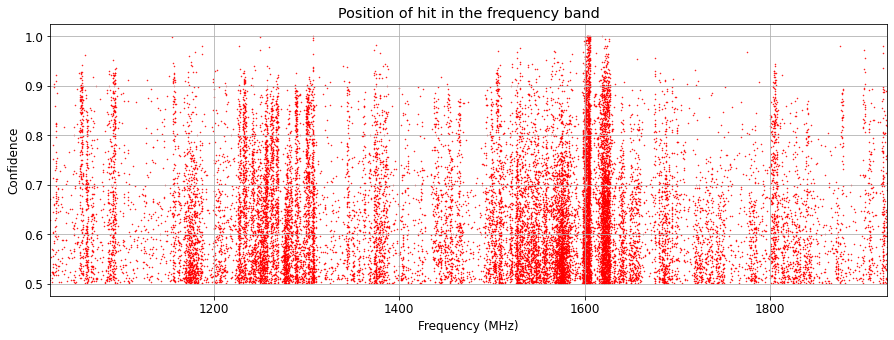

In [38]:
plot_all_hits(all_targets)

plt.gcf().set_size_inches(15, 5)    
plt.show()

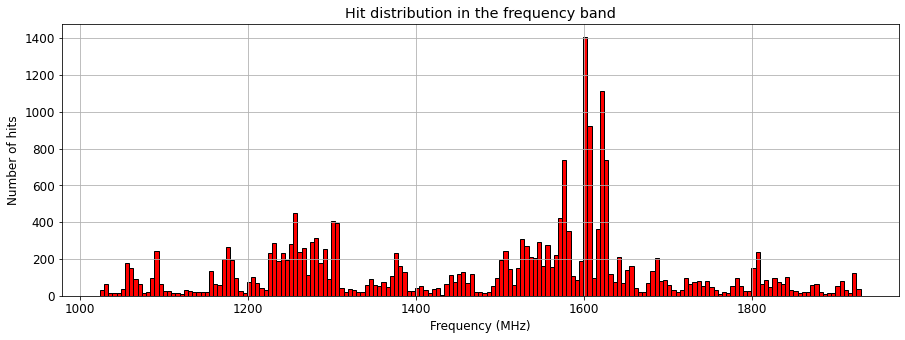

In [46]:
hist_all_hits(all_targets)

plt.gcf().set_size_inches(15, 5)    
plt.show()

In [19]:
# To pick a target, redefine i or directly define target as the corresponding string:
i = 1
target = Target(all_targets[i])
#target = Target('HIP2')

In [20]:
target.num_hits

1218

In [21]:
tab = ' ' * (10 - len('Hit index'))
j_list = []

print('Hit index', tab, 'Probability')
for j in range(len(target.hits)):
    if target.hits[j][2] > 0.9:
        tab = ' ' * (10 - len(str(j)))
        j_list.append(j)
        print(j, tab, target.hits[j][2])
print('\nlen =', len(j_list))

Hit index   Probability
39          0.911
72          0.907
78          0.916
89          0.931
93          0.923
146         0.941
272         0.927
409         0.972
439         0.918
474         0.931
658         0.946
713         0.909
748         0.908
762         0.901
798         0.919
822         0.977
823         0.948
834         0.915
839         0.914
845         0.902
985         0.902
988         0.933
989         0.918
999         0.912
1046        0.927
1052        0.91
1091        0.909

len = 27


In [22]:
k = 0

# To pick a hit, redefine j
j = j_list[k]
hit = Hit(target, j)

In [23]:
tab = ' ' * (16 - len('Target number'))
print('Target number', tab, 'Number of 90% hits')

k_sum = 0

for i in range(len(all_targets)):
    target = Target(all_targets[i])
    
    k = 0
    for j in range(len(target.hits)):
        if target.hits[j][2] > 0.9:
            k += 1
            k_sum += 1
    
    tab = ' ' * (16 - len(str(i + 1)))
    print(i + 1, tab, k)

print('\nTotal number of 90% hits:', k_sum)

Target number     Number of 90% hits
1                 34
2                 27
3                 45
4                 44
5                 50
6                 41
7                 115
8                 50
9                 16
10                57
11                44
12                38

Total number of 90% hits: 561


In [24]:
# progress = 0

# for target_name in all_targets:
#     target = Target(target_name)
    
#     for j in range(len(target.hits)):
#         if target.hits[j][2] > 0.9:
#             hit = Hit(target, j)
        
#             ID = hit.get_ID(all_targets)
#             start = hit.start_freq
#             stop = hit.end_freq
#             mid = (start + stop) / 2

#             make_waterfall_plots_full(filenames_list=target.cadence, target=target.name, 
#                                       f_start=start, f_stop=stop, correction_in=mid)

#             plt.suptitle('Candidate ' + ID)
#             plt.gcf().set_size_inches(12, 6)    
#             plt.savefig('../Documents/waterfall_plots_BLPC2/candidate-' + ID)
#             plt.close()

#             progress += 1
#             print(progress, '/', k_sum, 'complete.')

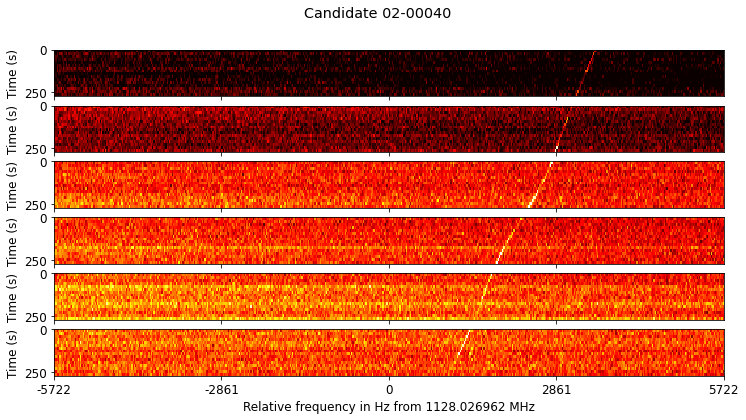

In [25]:
diff = hit.end_freq - hit.start_freq

start = hit.start_freq #- diff
stop = hit.end_freq #+ diff
mid = (start + stop) / 2

make_waterfall_plots_full(filenames_list=target.cadence, target=target.name, 
                          f_start=start, f_stop=stop, correction_in=mid)

plt.suptitle('Candidate ' + hit.get_ID(all_targets))
plt.gcf().set_size_inches(12, 6)  
plt.show()

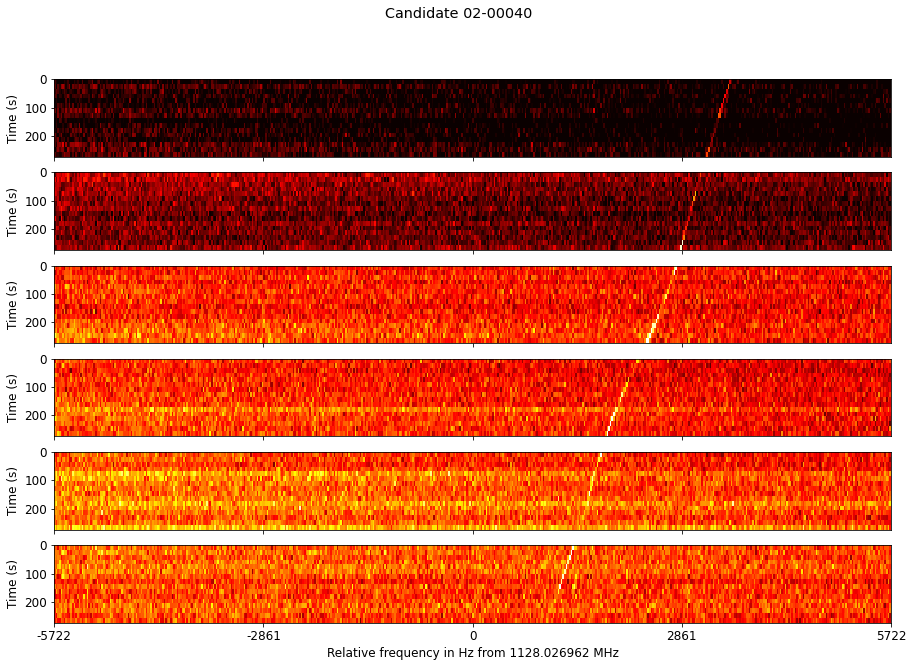

In [26]:
diff = hit.end_freq - hit.start_freq

start = hit.start_freq #- diff
stop = hit.end_freq #+ diff
mid = (start + stop) / 2

make_waterfall_plots_full(filenames_list=target.cadence, target=target.name, 
                          f_start=start, f_stop=stop, correction_in=mid)

plt.suptitle('Candidate ' + hit.get_ID(all_targets))
plt.gcf().set_size_inches(15, 10)    
plt.show()

					Candidate information

Target name: HIP114622                                Number of hits for this target: 1218
Right ascension: 23h13m20.987s                        Average number of hits per target: 1908.5
Declination: 57d10m08.941s
Telescope: GBT
Observation start (MJD): 57804.61493055556            		Hit #1000 of 1218
Observation start (ISOT): 2017-02-20T14:45:30.000     Start frequency: 1600.0785827636719 MHz
Observing time: 300s x 3                              End frequency: 1600.0900268554688 MHz
Cadence: ABACAD                                       Event bandwidth: 11444.091796875 Hz
Min frequency: 1023.9257840439677 MHz                 Probability: 91.2%
Max frequency: 1926.26953125 MHz                      Candidate ID: 02-01000


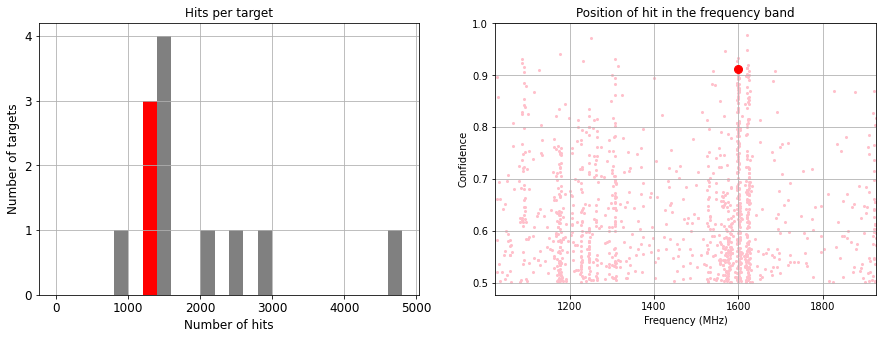

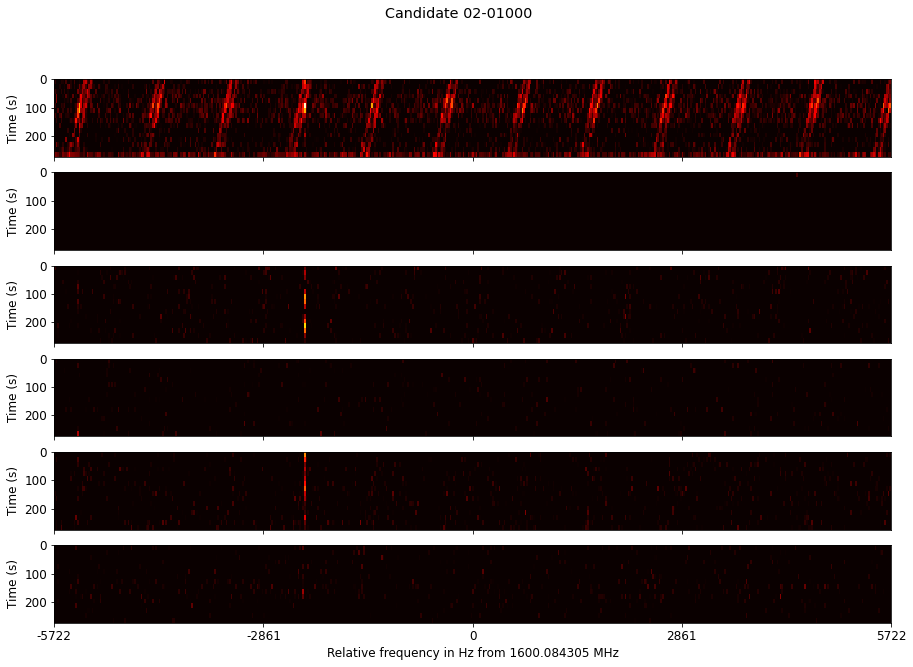

In [27]:
i = 1
j = 999

target = Target(all_targets[i])
hit = Hit(target, j)

print('\t\t\t\t\tCandidate information\n')

hit.print_info(all_targets)


plt.subplot(1, 2, 1)
plot_highlighted_hist(target)

plt.subplot(1, 2, 2)
hit.make_plot()

plt.gcf().set_size_inches(15, 5)    
plt.show()


diff = hit.end_freq - hit.start_freq

start = hit.start_freq #- diff
stop = hit.end_freq #+ diff
mid = (start + stop) / 2

make_waterfall_plots_full(filenames_list=target.cadence, target=target.name, 
                          f_start=start, f_stop=stop, correction_in=mid)

plt.suptitle('Candidate ' + hit.get_ID(all_targets))
plt.gcf().set_size_inches(15, 10)    
plt.show()

					Candidate information

Target name: HIP114622                                Number of hits for this target: 1218
Right ascension: 23h13m20.987s                        Average number of hits per target: 1908.5
Declination: 57d10m08.941s
Telescope: GBT
Observation start (MJD): 57804.61493055556            		Hit #40 of 1218
Observation start (ISOT): 2017-02-20T14:45:30.000     Start frequency: 1128.021240234375 MHz
Observing time: 300s x 3                              End frequency: 1128.0326843261719 MHz
Cadence: ABACAD                                       Event bandwidth: 11444.091796875 Hz
Min frequency: 1023.9257840439677 MHz                 Probability: 91.10000000000001%
Max frequency: 1926.26953125 MHz                      Candidate ID: 02-00040


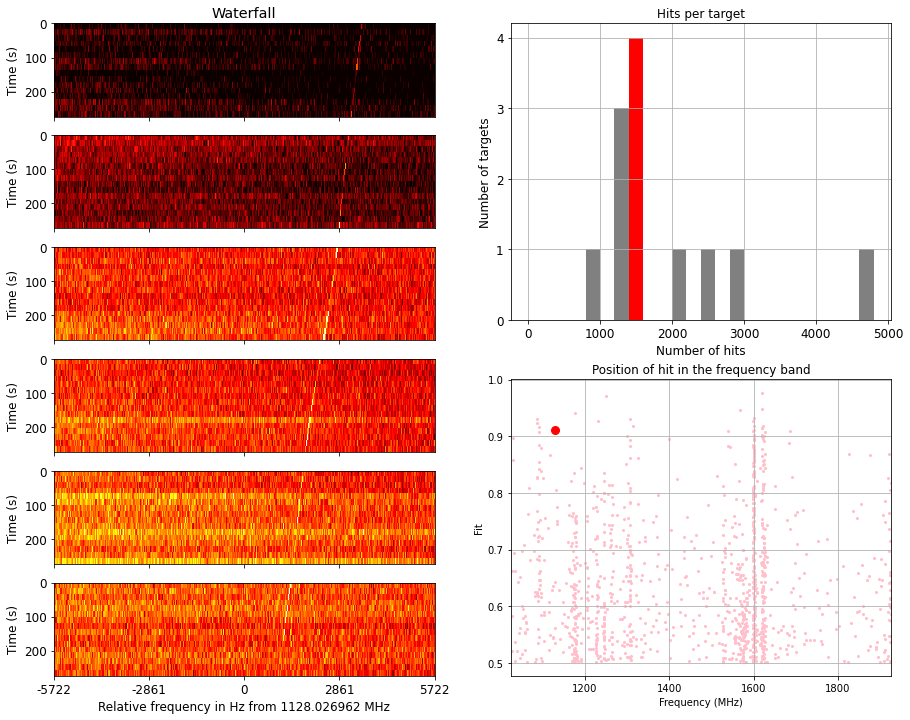

In [35]:
print('\t\t\t\t\tCandidate information\n')

hit.print_info(all_targets)


diff = hit.end_freq - hit.start_freq

start = hit.start_freq #- diff
stop = hit.end_freq #+ diff
mid = (start + stop) / 2

make_waterfall_plots(filenames_list=target.cadence, target=target.name, 
                     f_start=start, f_stop=stop, correction_in=mid)


plt.subplot(2, 2, 2)
plot_highlighted_hist(target)

plt.subplot(2, 2, 4)
hit.make_plot()

plt.gcf().set_size_inches(15, 12)    
plt.show()

					Candidate information

Target name: GJ473AB                                  Number of hits for this target: 397
Right ascension: 12h33m15.398s                        Average number of hits per target: 2485.7710843373493
Declination: 9d01m19.002s
Telescope: GBT
Observation start (MJD): 57522.12740740741            		Hit #52 of 397
Observation start (ISOT): 2016-05-14T03:03:28.000     Start frequency: 1526.7323096041873 MHz
Observing time: 300s x 3                              End frequency: 1526.7439238261893 MHz
Cadence: ABACAD                                       Event bandwidth: 11614.222001981034 Hz
Min frequency: 1023.9257840855033 MHz                 Probability: 51.9%
Max frequency: 1926.26953125 MHz                      Candidate ID: 01-00052


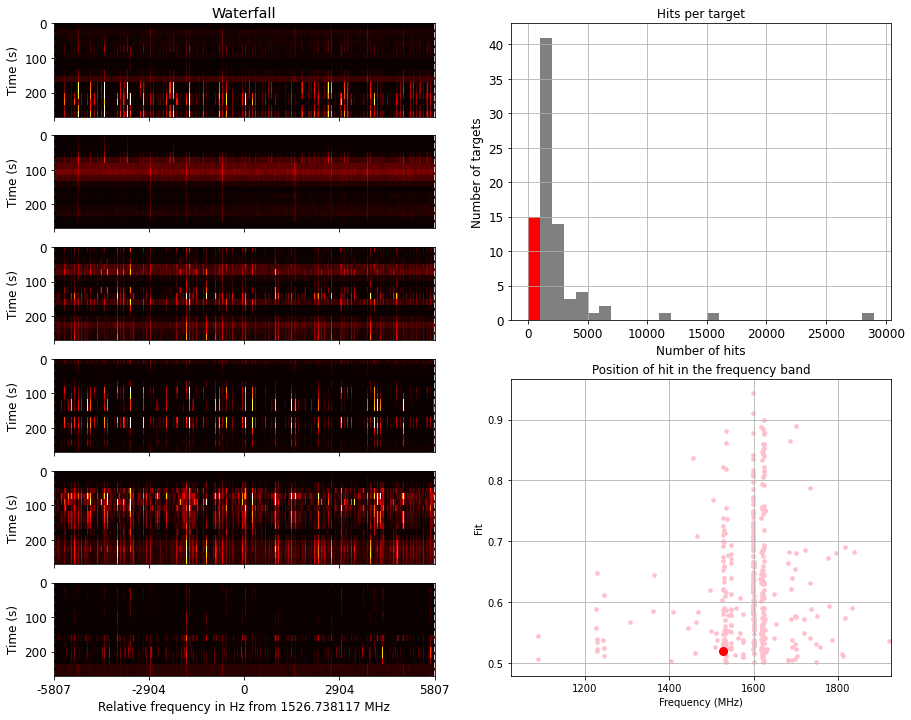

In [66]:
print('\t\t\t\t\tCandidate information\n')

hit.print_info(all_targets)


diff = hit.end_freq - hit.start_freq

start = hit.start_freq #- diff
stop = hit.end_freq #+ diff
mid = (start + stop) / 2

make_waterfall_plots(filenames_list=target.cadence, target=target.name, 
                     f_start=start, f_stop=stop, correction_in=mid, 
                     line1=hit.start_freq, line2=hit.end_freq)


plt.subplot(2, 2, 2)
plot_highlighted_hist(target)

plt.subplot(2, 2, 4)
hit.make_plot()

plt.gcf().set_size_inches(15, 12)    
plt.show()

					Candidate information

Target name: GJ473AB                                  Number of hits for this target: 397
Right ascension: 12h33m15.398s                        Average number of hits per target: 2485.7710843373493
Declination: 9d01m19.002s
Telescope: GBT
Observation start (MJD): 57522.12740740741            		Hit #52 of 397
Observation start (ISOT): 2016-05-14T03:03:28.000     Start frequency: 1526.7323096041873 MHz
Observing time: 300s x 3                              End frequency: 1526.7439238261893 MHz
Cadence: ABACAD                                       Event bandwidth: 11614.222001981034 Hz
Min frequency: 1023.9257840855033 MHz                 Probability: 51.9%
Max frequency: 1926.26953125 MHz                      Candidate ID: 01-00052


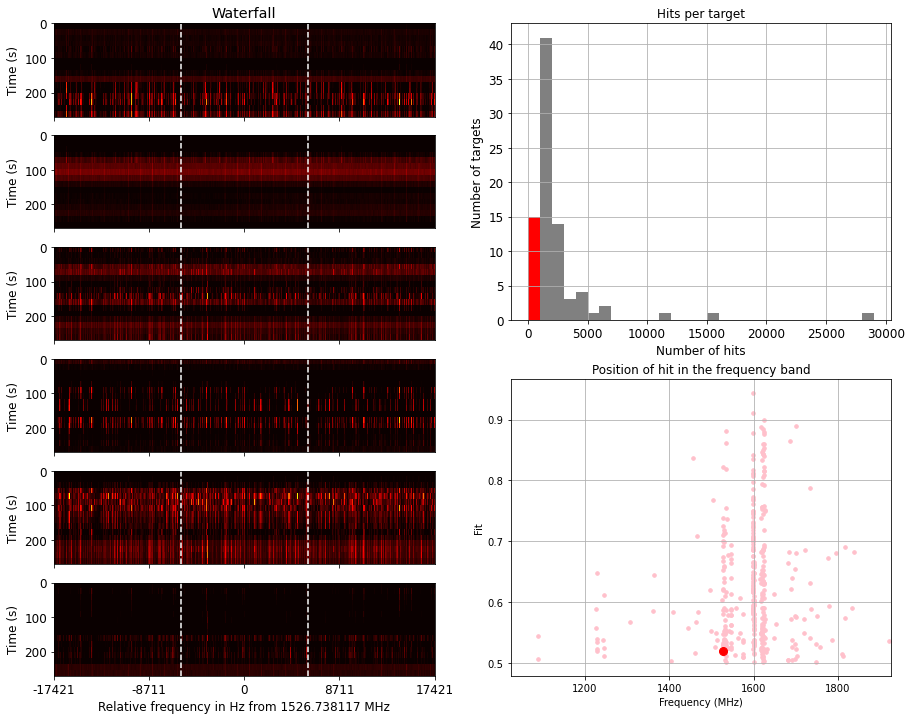

In [67]:
print('\t\t\t\t\tCandidate information\n')

hit.print_info(all_targets)


diff = hit.end_freq - hit.start_freq

start = hit.start_freq - diff
stop = hit.end_freq + diff
mid = (start + stop) / 2

make_waterfall_plots(filenames_list=target.cadence, target=target.name, 
                     f_start=start, f_stop=stop, correction_in=mid, 
                     line1=hit.start_freq, line2=hit.end_freq)


plt.subplot(2, 2, 2)
plot_highlighted_hist(target)

plt.subplot(2, 2, 4)
hit.make_plot()

plt.gcf().set_size_inches(15, 12)    
plt.show()